In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for SVM and XGBOOST
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,precision_recall_curve, auc


import xgboost as xgb

In [21]:
df = pd.read_csv("df_final-4")

In [22]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'game', 'round', 'start round', 'hit',
       'duration round', 'participant', 'accelarator press',
       'accelarator first signal', 'start heartrate in video',
       'start heartrate in actual time', 'hit, correct', 'hit, incorrect',
       'other hit, correct', 'other hit, incorrect', 'confidence score',
       'experience score', 'games played prior on current day', 'start video',
       'winner_streak', 'prev_round_hit_corr', 'favorite fruit_prume',
       'favorite fruit_strawberry', 'accelarator device_band',
       'accelarator device_elastics', 'accelarator press_seconds',
       'accelarator first signal_seconds', 'hit_seconds',
       'start heartrate in video_seconds', 'duration round_seconds', 'no_hit',
       'time_hit_to_hit', 'accelerator_press_hit_adj_time',
       'accelerator_signal_hit_adj_time', 'heartrate_adj_time', 'before3_mean',
       'before3_min', 'before3_max', 'before2_mean', 'before2_min',
       'before2_max', 'befo

In [9]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'game', 'round', 'start round', 'hit',
       'participant', 'accelarator press', 'accelarator first signal',
       'start heartrate in video', 'start heartrate in actual time',
       'hit, correct', 'hit, incorrect', 'other hit, correct',
       'other hit, incorrect', 'confidence score', 'experience score',
       'games played prior on current day', 'start video',
       'favorite fruit_prume', 'favorite fruit_strawberry',
       'accelarator device_band', 'accelarator device_elastics',
       'accelarator press_seconds', 'accelarator first signal_seconds',
       'hit_seconds', 'start heartrate in video_seconds', 'no_hit',
       'time_hit_to_hit', 'accelerator_press_hit_adj_time',
       'accelerator_signal_hit_adj_time', 'heartrate_adj_time', 'before3_mean',
       'before3_min', 'before3_max', 'before2_mean', 'before2_min',
       'before2_max', 'before1_mean', 'before1_min', 'before1_max',
       'after1_mean', 'after1_min', 'after1_max', 

In [23]:
df['target'] = df[['hit, correct', 'hit, incorrect','other hit, correct', 'other hit, incorrect', 'no_hit']].idxmax(axis=1)
# 0: hit, correct 1: hit,incorrect 2:other hit, correct 3: other hit, incorrect 4: no hit

#df = df.drop(columns=['hit, correct', 'hit, incorrect','other hit, correct', 'other hit, incorrect', 'no_hit'])

# Encode the target variable as categorz
df['target'] = df['target'].astype('category').cat.codes

In [24]:
#23 nan values in confidence score were removed with backward fill
#backward fill confidence score
def backward_fill_confidence(df):
    for index, row in df.iterrows():
        if pd.isna(row['confidence score']):
            target_value = row['target']
            # Find the most recent non-NaN confidence_score with the same target
            for i in range(index - 1, -1, -1):
                if df.loc[i, 'target'] == target_value and not pd.isna(df.loc[i, 'confidence score']):
                    df.loc[index, 'confidence score'] = df.loc[i, 'confidence score']
                    break
    return df

# Impute the NaN values using the backward fill approach
df = backward_fill_confidence(df)

print(df)

     Unnamed: 0.1  Unnamed: 0  game  round   start round           hit  \
0               0          71     1      1  00:02:21:690  00:02:29:840   
1               1          53     1      1  00:02:21:690  00:03:05.040   
2               2          72     1      2  00:03:16:840  00:03:40:240   
3               3          68     1      2  00:03:16:840  00:04:49.540   
4               4          73     1      3  00:05:57:630  00:05:58:840   
..            ...         ...   ...    ...           ...           ...   
389           423         423     6    118  00:44:40:750  00:44:43:630   
390           424         424     6    119  00:44:50:750  00:44:53:810   
391           425         425     6    120  00:45:01:630  00:45:07:030   
392           426         426     6    121  00:45:12:090  00:45:16:570   
393           427         427     6    122  00:45:23:090  00:45:29:570   

    duration round participant accelarator press accelarator first signal  \
0     00:00:08:150       Paula    

In [25]:
#9 missing lines for heartrate at the end of game 2. does not make sense to impute, so we drop them
print(df[df['after1_mean'].isna()])

    Unnamed: 0.1  Unnamed: 0  game  round   start round           hit  \
60            60         106     2     12  00:13:32:000  00:13:45:750   
61            61          34     2     12  00:13:32:000  00:14:08.420   
62            62         107     2     13  00:14:22:030  00:14:31:090   
63            63          10     2     13  00:14:22:030  00:14:48.815   
64            64         108     2     14  00:15:03:840  00:15:06:540   
65            65          22     2     14  00:15:03:840  00:15:26.920   
66            66         109     2     15  00:15:36:840  00:15:47:300   
67            67          45     2     15  00:15:36:840  00:16:15.585   
68            68         110     2     16  00:16:26:720  00:16:43:870   

   duration round participant accelarator press accelarator first signal  ...  \
60   00:00:13:750        Luna      00:00:07:360             00:00:07:540  ...   
61   00:00:13:750        Luna      00:00:07:360             00:00:07:540  ...   
62   00:00:09:060        L

In [26]:
# drop nan lines
#print(df.isna().sum())
df = df.dropna()
df.reset_index(drop=True)



,Unnamed: 0.1,Unnamed: 0,game,round,start round,hit,duration round,participant,accelarator press,accelarator first signal,...,after2_mean,after2_min,after2_max,after3_mean,after3_min,after3_max,max_acc_value,max_acc_time,time_diff_max_acc,target
0,0,71,1,1,00:02:21:690,00:02:29:840,00:00:08:150,Paula,00:00:05:660,00:00:06:120,...,92.193200,90.6071,93.7793,99.11715,97.5293,100.7050,34.180308,144.177022,0.457022,0
1,1,53,1,1,00:02:21:690,00:03:05.040,00:00:08:150,Paula,00:00:05:660,00:00:06:120,...,65.431200,65.2600,65.6024,67.92575,66.7111,69.1404,0.596726,180.916712,1.996712,2
2,2,72,1,2,00:03:16:840,00:03:40:240,00:00:23:300,Paula,00:00:05:660,00:00:06:120,...,69.622350,69.4123,69.8324,70.38970,70.2741,70.5550,7.981536,214.630847,0.510847,3
3,3,68,1,2,00:03:16:840,00:04:49.540,00:00:23:300,Paula,00:00:05:660,00:00:06:120,...,85.569367,81.5883,89.5522,92.82380,92.3930,93.2546,0.134234,283.837576,0.417575,2
4,4,73,1,3,00:05:57:630,00:05:58:840,00:00:01:210,Paula,00:00:05:660,00:00:06:120,...,72.887550,72.0288,73.7463,69.44310,68.7600,70.1262,45.340704,353.235138,0.515137,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,423,423,6,118,00:44:40:750,00:44:43:630,00:00:02:750,Luna,00:00:10:870,00:00:11:360,...,78.860700,77.7001,80.0213,75.19155,74.2023,76.1808,19.985016,2672.515326,0.245326,0
381,424,424,6,119,00:44:50:750,00:44:53:810,00:00:03:030,Luna,00:00:10:870,00:00:11:360,...,59.761000,59.7491,59.7729,61.29690,60.8273,61.7665,23.706996,2682.626484,0.176484,4
382,425,425,6,120,00:45:01:630,00:45:07:030,00:00:05:300,Luna,00:00:10:870,00:00:11:360,...,78.169000,77.6598,78.6782,76.88150,75.7193,78.0437,15.815210,2695.894873,0.224873,3
383,426,426,6,121,00:45:12:090,00:45:16:570,00:00:04:450,Luna,00:00:10:870,00:00:11:360,...,71.209450,70.9052,71.5137,72.83180,72.0981,73.5655,25.682024,2705.446514,0.236514,0


In [30]:
print(df.isna().sum())

Unnamed: 0.1                         0
Unnamed: 0                           0
game                                 0
round                                0
start round                          0
hit                                  0
duration round                       0
participant                          0
accelarator press                    0
accelarator first signal             0
start heartrate in video             0
start heartrate in actual time       0
hit, correct                         0
hit, incorrect                       0
other hit, correct                   0
other hit, incorrect                 0
confidence score                     0
experience score                     0
games played prior on current day    0
start video                          0
winner_streak                        0
prev_round_hit_corr                  0
favorite fruit_prume                 0
favorite fruit_strawberry            0
accelarator device_band              0
accelarator device_elasti

In [29]:
df.to_csv('df_FINAL')

In [32]:
df = pd.read_csv('cleaned_updated_balanced_data.csv')

In [84]:
print(df[['target',  'other hit, incorrect']])
# 0: hit, correct 1: hit,incorrect 2: no hit 3: other hit, correct 4: other hit, incorrect

     target  other hit, incorrect
0         0                   0.0
1         2                   0.0
2         3                   0.0
3         2                   0.0
4         3                   0.0
..      ...                   ...
254       0                   0.0
255       0                   0.0
256       1                   0.0
257       1                   0.0
258       3                   0.0

[248 rows x 2 columns]


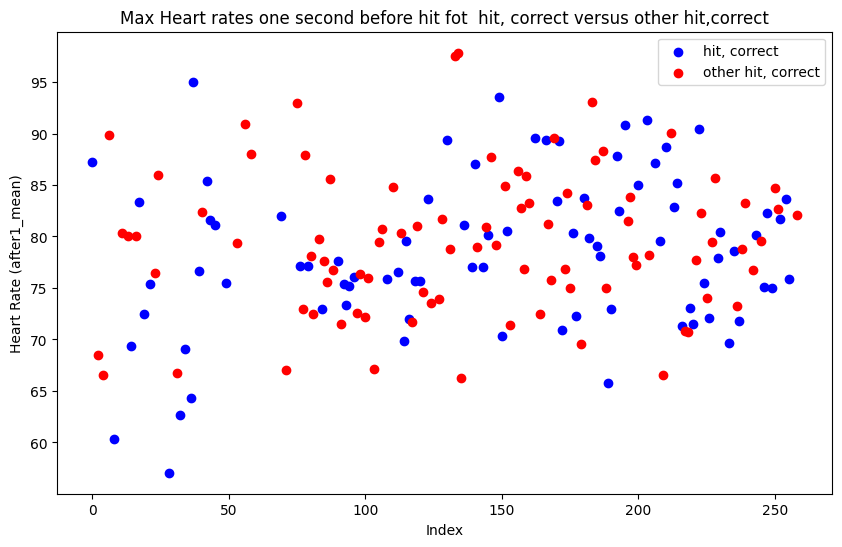

In [90]:
# Filter the data for category 2 and category 3
category_2 = df[df['target'] == 0]
category_3 = df[df['target'] == 3]

# Plot the heart rates in after1_mean for category 2 and category 3
plt.figure(figsize=(10, 6))

# Plot for category 2
plt.scatter(category_2['before2_max'].index, category_2['before2_max'],label='hit, correct', color='blue')

# Plot for category 3
plt.scatter(category_3['before2_max'].index, category_3['before2_max'],label='other hit, correct', color='red')

# Adding title and labels
plt.title('Max Heart rates one second before hit fot  hit, correct versus other hit,correct')
plt.xlabel('Index')
plt.ylabel('Heart Rate (after1_mean)')
plt.legend()

# Show the plot
plt.show()

In [64]:
print(len(df[df['target'] == 4]))
#0:139 1:137 2:135 3;137 4:137

137


In [ ]:
[ 'participant',
'confidence score', 'experience score',
       'games played prior on current day',  'winner_streak',
       'favorite fruit_prume',
       'favorite fruit_strawberry',  'duration round_seconds',  'before3_mean',
       'before3_min', 'before3_max', 'before2_mean', 'before2_min',
       'before2_max', 'before1_mean', 'before1_min', 'before1_max',
       'after1_mean', 'after1_min', 'after1_max', 'after2_mean', 'after2_min',
       'after2_max', 'after3_mean', 'after3_min', 'after3_max',
       'max_acc_value',  'time_diff_max_acc',


In [77]:
#features
X = df['before1_mean']
features = ['before1_mean']
#X = df[['confidence score','before1_mean', 'before1_min', 'before1_max','after1_mean', 'after1_min', 'after1_max','max_acc_value', 'time_diff_max_acc']]

y = df['target']


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = X_train.values.reshape(-1,1)
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
X_test = X_test.values.reshape(-1,1)


In [79]:
#Multiclass SVM
svm_model = SVC(class_weight='balanced', decision_function_shape='ovr')

# Train the model
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced')

In [80]:

# Make predictions
y_pred = svm_model.predict(X_test)
print("SVM")
print(f'Features: {features}')

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# If you want to calculate ROC-AUC for multiclass
y_test_bin = pd.get_dummies(y_test)
y_pred_bin = pd.get_dummies(y_pred)
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
print(f'ROC-AUC Score: {roc_auc}')

SVM
Features: ['before1_mean']
              precision    recall  f1-score   support

           0       0.26      0.19      0.22        27
           1       0.30      0.32      0.31        25
           2       0.28      0.45      0.34        22
           3       0.32      0.31      0.32        39
           4       0.33      0.25      0.29        24

    accuracy                           0.30       137
   macro avg       0.30      0.30      0.29       137
weighted avg       0.30      0.30      0.29       137

[[ 5  7  7  6  2]
 [ 3  8  4  9  1]
 [ 2  2 10  6  2]
 [ 6  5  9 12  7]
 [ 3  5  6  4  6]]
ROC-AUC Score: 0.563312367540381


In [81]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predict probabilities
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve for positive class 'hit_correct' (class 0 in binary)
precision, recall, thresholds = precision_recall_curve(y_test == 0, y_probs)

# Calculate AUC for precision-recall curve
auc_score = auc(recall, precision)

# Print results
#print("Precision-Recall Curve:")
#for p, r, t in zip(precision, recall, thresholds):
    #print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")
print("XGBOOST")
print(f'Features: {features}')

# Evaluate the model
y_pred = xgb_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


XGBOOST
Features: ['before1_mean']

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.33      0.35        27
           1       0.65      0.96      0.77        25
           2       0.45      0.68      0.55        22
           3       0.54      0.18      0.27        39
           4       0.73      0.92      0.81        24

    accuracy                           0.56       137
   macro avg       0.55      0.61      0.55       137
weighted avg       0.55      0.56      0.52       137

Confusion Matrix:
[[ 9  7  5  1  5]
 [ 1 24  0  0  0]
 [ 4  0 15  3  0]
 [10  6 13  7  3]
 [ 0  0  0  2 22]]
